In [4]:
import sys
sys.path.append('../Instruments/network/VNA')
sys.path.append('../Instruments/network/Signal_Generator')
sys.path.append('../Instruments/SRS/voltage_source')
sys.path.append('../HDF5')

import NA_N9916A
import RS_SMA100B
import SIM928
import HDF5
import numpy as np
import matplotlib.pyplot as plt
import time

volt = SIM928.SIM928()
vna  = NA_N9916A.N9916A('192.168.40.10')
pump = RS_SMA100B.SMA100B('192.168.40.15')


Connection successful!
Connection successful!
Connection successful!


## Get data without pump

In [5]:
file_name   = 'twpa_2.hdf5'         #presa dati con freq da 0 a8 GHz
data        = vna.get_data()

HDF5.write(file_name, 'twpa_without_pump', 0, data)

## Get data with pump

In [ ]:
# signal generator
N = 20
pump_min = 7.6
pump_max = 7.9
step = (pump_max - pump_min)/N
freq_pump = np.arange(pump_min, pump_max, step)

# vna
f_min = 1
f_max = 6
vna.set_freq_range(f_min, f_max)

pump.RF_state(1)
for i in freq_pump:
    pump.RF_freq(i*1e3)
    time.sleep(16)              # Maroo dice che è inutile, 14 s è solo tempo per interfaccia del VNA
    data = vna.get_data()
    HDF5.write(file_name, 'twpa_with_pump', i, data)
    print('Freq pump:', i)
    volt.output_off()           # These stop and go are needed to avoid warming up of qubit (40 to 60 mK)
    time.sleep(0.5)
    volt.output_on()
pump.RF_state(0)
volt.output_off()
print('Done.')

In [8]:
import h5py
file_name = 'twpa.hdf5'

with h5py.File(file_name, 'r') as f:
		data_pump = {}
		no_pump = {}
		
		for i, k in f['with_pump'].items():
			subdic = {}
			for j, c in k.items():
				subdic[j] = c[()]
			data_pump[i] = subdic

		for i, k in f['without_pump'].items():
			no_pump[i] = k[()]

In [ ]:
y = np.array([float(i) for i in list(data_pump.keys())])
gain = {}
for i,k in data_pump.items():
    I = np.array(k['I'])
    Q = np.array(k['Q'])
    f = np.array(k['f'])
    G = 20*np.log10(I**2 + Q**2)
    gain[i] = {'G': G,'f':f}


Inp = np.array(no_pump['I'])
Qnp = np.array(no_pump['Q'])
Gnp = 20*np.log10(Inp**2 + Qnp**2)

print(y)


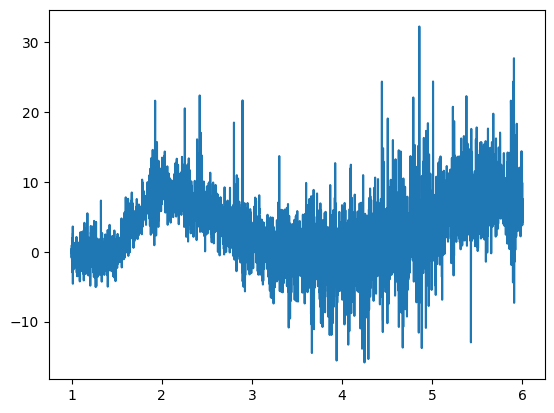

In [34]:
c = gain['7.8']['G']-Gnp
plt.plot(f,c)

In [17]:

# Python program to calculate
# simple moving averages using pandas
import pandas as pd
 
window_size = 51
a = int((window_size-1)/2)
gain_avg = {}


for i in gain.keys():
    c = gain[i]['G']-Gnp
    # Convert array of integers to pandas series
    numbers_series = pd.Series(c)
    
    # Get the window of series
    # of observations of specified window size
    windows = numbers_series.rolling(window_size)
    
    # Create a series of moving
    # averages of each window
    moving_averages = windows.mean()
    
    # Convert pandas series back to list
    moving_averages_list = moving_averages.tolist()
    
    # Remove null entries from the list
    final_list = moving_averages_list[window_size - 1:]
    gain_avg[i] = {'G':final_list, 'f': f[a:-a]}



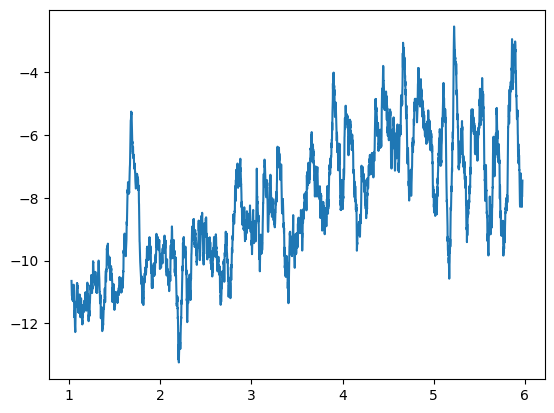

In [18]:
f_pump = '7.62'
plt.plot(gain_avg[f_pump]['f'], gain_avg[f_pump]['G'])

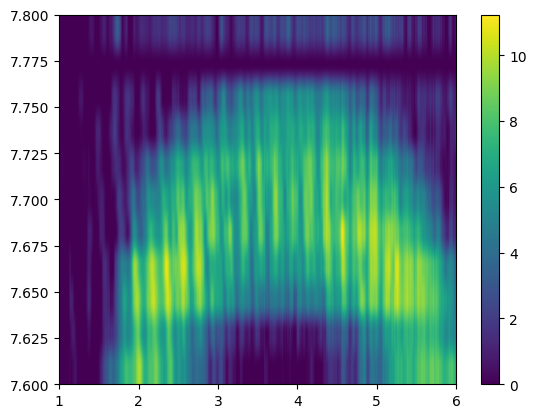

In [21]:
import matplotlib.pyplot as plt
import numpy as np


# Crea una meshgrid per gli assi x e y
X, Y = np.meshgrid(f[a:-a], y)
data = []
for i in gain_avg.keys():
    data.append(gain_avg[i]['G'])


data = np.array(data)
data[data < 0.0] = 0.0

plt.imshow(data, cmap='viridis', aspect='auto', extent=[1, 6, 7.6, 7.8])

colorbar = plt.colorbar()

plt.show()


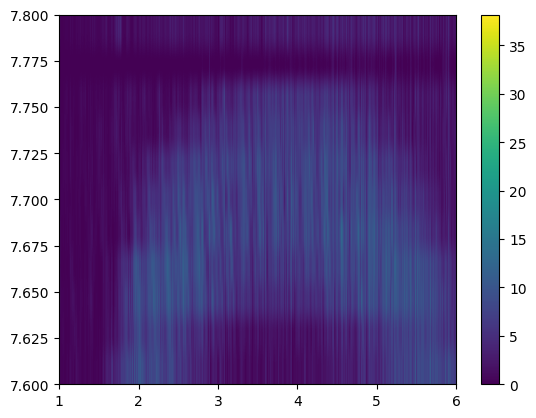

In [32]:
import matplotlib.pyplot as plt
import numpy as np


# Crea una meshgrid per gli assi x e y
X, Y = np.meshgrid(f[a:-a], y)
data = []
for i in gain.keys():
    data.append(gain[i]['G']- Gnp)


data = np.array(data)
data[data < 0.0] = 0.0

plt.imshow(data, cmap='viridis', aspect='auto', extent=[1, 6, 7.6, 7.8])

colorbar = plt.colorbar()

plt.show()